In [4]:
import torch

class LossFunction:
    def __init__(self, alpha=1.0, eps=1e-8, use_regularization=False):
        """
        Initialize the loss function with given parameters.
        
        Args:
            alpha (float): Scaling parameter for edge probability.
            eps (float): Small value to prevent log(0).
            use_regularization (bool): Whether to include Gaussian regularization.
        """
        self.alpha = alpha
        self.eps = eps
        self.use_regularization = use_regularization

    def edge_probability(self, z_i, z_j):
        """Compute the probability of an edge existing between two embeddings."""
        dist = torch.norm(z_i - z_j) ** 2  # Squared Euclidean distance
        return 1 / (1 + torch.exp(-self.alpha + dist))  # Logistic function

    def link_loss(self, label, z_u, z_v):
        """Compute the loss for a single edge."""
        prob = self.edge_probability(z_u, z_v)
        prob = torch.clamp(prob, self.eps, 1 - self.eps)  # Numerical stability

        return label.float() * torch.log(prob) + (1 - label.float()) * torch.log(1 - prob)

    def compute_loss(self, z, datamatrix_tensor):
        """Compute the total loss for the dataset."""
        sum_loss = sum(
            self.link_loss(label, z[u_idx], z[v_idx])
            for label, u_idx, v_idx in datamatrix_tensor
        )

        loss = -sum_loss / len(datamatrix_tensor)

        if self.use_regularization:
            regularization = -0.5 * torch.sum(z ** 2)
            loss += regularization

        return loss
    

# loss_fn = LossFunction(alpha=1.0, use_regularization=True)
# loss_value = loss_fn.compute_loss(z, datamatrix_tensor)

True Category Assignments:
B0 -> C3
B1 -> C3
B2 -> C1
B3 -> C4
B4 -> C1
B5 -> C1
B6 -> C1
B7 -> C1
B8 -> C0
B9 -> C2
Epoch 0: Loss = 0.4638
Epoch 100: Loss = 0.1126
Epoch 200: Loss = 0.0707
Epoch 300: Loss = 0.0441
Epoch 400: Loss = 0.0332
Category Prediction Accuracy: 0.4000


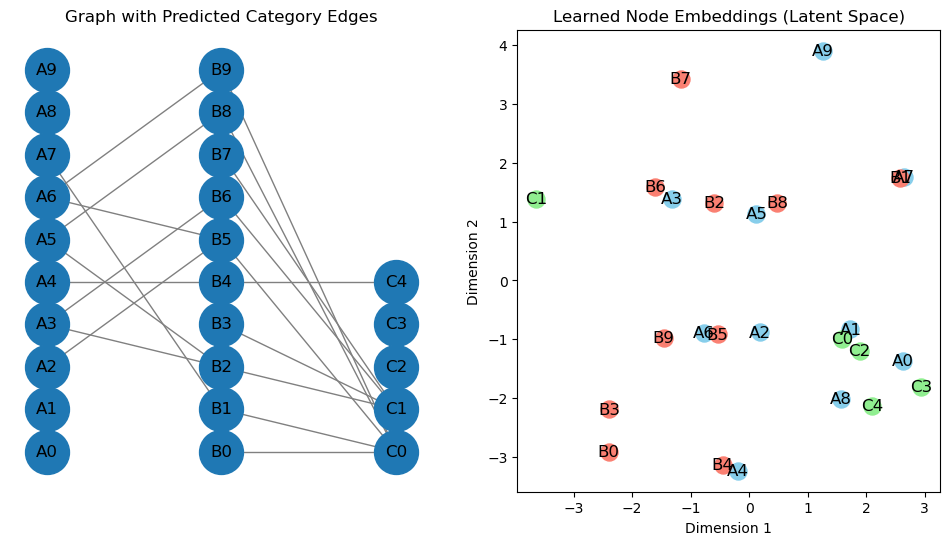

In [5]:
import networkx as nx
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np

# 1️ Generate Bipartite Graph with Known Category Assignments
random.seed(99)
num_nodes_set_1 = 10  # Left column (A nodes)
num_nodes_set_2 = 10  # Middle column (B nodes)
num_nodes_set_3 = 5   # Right column (C nodes, predefined categories)

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
nodes_set_3 = [f"C{i}" for i in range(num_nodes_set_3)]
all_nodes = nodes_set_1 + nodes_set_2 + nodes_set_3

# Predefine category assignments for B nodes
true_categories = {nodes_set_2[i]: random.choice(nodes_set_3) for i in range(num_nodes_set_2)}
print("True Category Assignments:")
for b, c in true_categories.items():
    print(f"{b} -> {c}")

G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)
G.add_nodes_from(nodes_set_3, bipartite=2)

# Add edges between A and B
edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.9:  # 10% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# 2️ Create the Data Matrix (Edge / Non-Edge Pairs)
# Create the `datamatrix` for training
datamatrix = []

# Include edges between set_1 ↔ set_2 (for training)
for u in nodes_set_1:
    for v in nodes_set_2:
        label = 1 if (u, v) in edges or (v, u) in edges else 0
        u_idx = all_nodes.index(u)
        v_idx = all_nodes.index(v)
        datamatrix.append([label, u_idx, v_idx])

# Include edges between set_2 ↔ set_3 (for training)
for u in nodes_set_2:
    for v in nodes_set_3:
        label = 1 if (u, v) in edges or (v, u) in edges else 0
        u_idx = all_nodes.index(u)
        v_idx = all_nodes.index(v)
        datamatrix.append([label, u_idx, v_idx])

datamatrix = np.array(datamatrix)
datamatrix_tensor = torch.tensor(datamatrix, dtype=torch.long)

# 2️ Define Embeddings
embedding_dim = 2
node_embeddings = torch.nn.Embedding(len(all_nodes), embedding_dim)
optimizer = torch.optim.Adam(node_embeddings.parameters(), lr=0.01)

loss_function = LossFunction(alpha=1.0, eps=1e-10)

# 3️ Train Embeddings
alpha = 3
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    z = node_embeddings.weight  # Get embeddings
    loss = loss_function.compute_loss(z, datamatrix_tensor)  # Compute loss
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# 4️ Assign B nodes to C nodes using Shortest Latent Space Distance
emb_matrix = node_embeddings.weight.detach()
predicted_categories = {}
predicted_edges = []

# Loop over the B nodes
for b in nodes_set_2:
    b_idx = all_nodes.index(b)
    distances = []
    
    # For each C node, compute the Euclidean distance between their embeddings
    for c in nodes_set_3:
        c_idx = all_nodes.index(c)
        dist = torch.norm(emb_matrix[b_idx] - emb_matrix[c_idx])  # Euclidean distance
        distances.append((dist.item(), c))
    
    # Assign the C node with the shortest distance
    assigned_c = min(distances, key=lambda x: x[0])[1]  # Get the closest C node
    predicted_categories[b] = assigned_c
    predicted_edges.append((b, assigned_c))
    G.add_edge(b, assigned_c)  # Add edge to graph

# 5️ Compute Accuracy of Category Prediction
correct = sum(1 for b in nodes_set_2 if predicted_categories[b] == true_categories[b])
accuracy = correct / len(nodes_set_2)
print(f"Category Prediction Accuracy: {accuracy:.4f}")

# 6️ Plot Graph with Category Labels
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})
pos.update({node: (2, i) for i, node in enumerate(nodes_set_3)})
nx.draw(G, pos, with_labels=True, node_size=1000, edge_color="gray", ax=axes[0])
axes[0].set_title("Graph with Predicted Category Edges")

# 7️ Plot Latent Space
emb_array = emb_matrix.numpy()
for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else 'salmon' if node in nodes_set_2 else 'lightgreen'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')
axes[1].set_title("Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")
plt.show()
